In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Bidirectional

In [2]:
df_Tata = pd.read_csv("TATAMOTORS_with_indicators_.csv")

In [3]:
df_Tata['date'] = pd.DatetimeIndex(pd.date_range('2021-11-20 02:59:00+05:30', periods=len(df_Tata),  freq='min')) #sobreescribo mi columna date con nuevo range por minutos 
df_Tata = df_Tata.set_index('date') # pongo la columna fecha como indice. para facilitar el analisis.

df_Tata['year'] = df_Tata.index.year
df_Tata['month'] = df_Tata.index.month
df_Tata['day'] = df_Tata.index.day
df_Tata['weekday'] = df_Tata.index.day_name()
df_Tata['weekofyear'] = df_Tata.index.isocalendar().week
df_Tata['hour'] = df_Tata.index.hour
df_Tata['minute'] = df_Tata.index.minute

weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_Tata['weekday'] = df_Tata['weekday'].map(weekday_mapping)

# muestra de los datos por día
data_daily = df_Tata['close'].resample('D').mean()

df_Tata = df_Tata.drop(columns=["high","low"])
df_Tata = df_Tata.drop(columns=["sma20","sma10","sma15","ema5","ema10","ema15","middleband","lowerband","TRIMA5","TRIMA20","KAMA10","KAMA20","MOM10","MOM15","ROC10","ROC20","ATR","macd510","macd520","macd1020","macd1520","ADX5","ADX20"])


In [4]:
transformed_data = df_Tata.groupby(['day']).agg({'close':'sum'})
transformed_data['day'] = transformed_data.index

In [5]:
data_daily = df_Tata['close'].resample('T').mean()

In [6]:
n_features = 1
n_steps = 10

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def train_test_data(seq, steps):
    X, Y = list(), list()
    for i in range(len(seq)):
        sample = i + steps
        if sample > len(seq)-1:
            break
        x, y = seq[i:sample],seq[sample]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [8]:
def train_test_validation_plot(train_size, test_size):
    plt.figure(figsize=(12,9))
    plt.plot(data_daily[:train_size])
    plt.plot(data_daily[train_size:test_size])
    plt.plot(data_daily[test_size:])

Training size: 104277
Training + Validation size: 117312


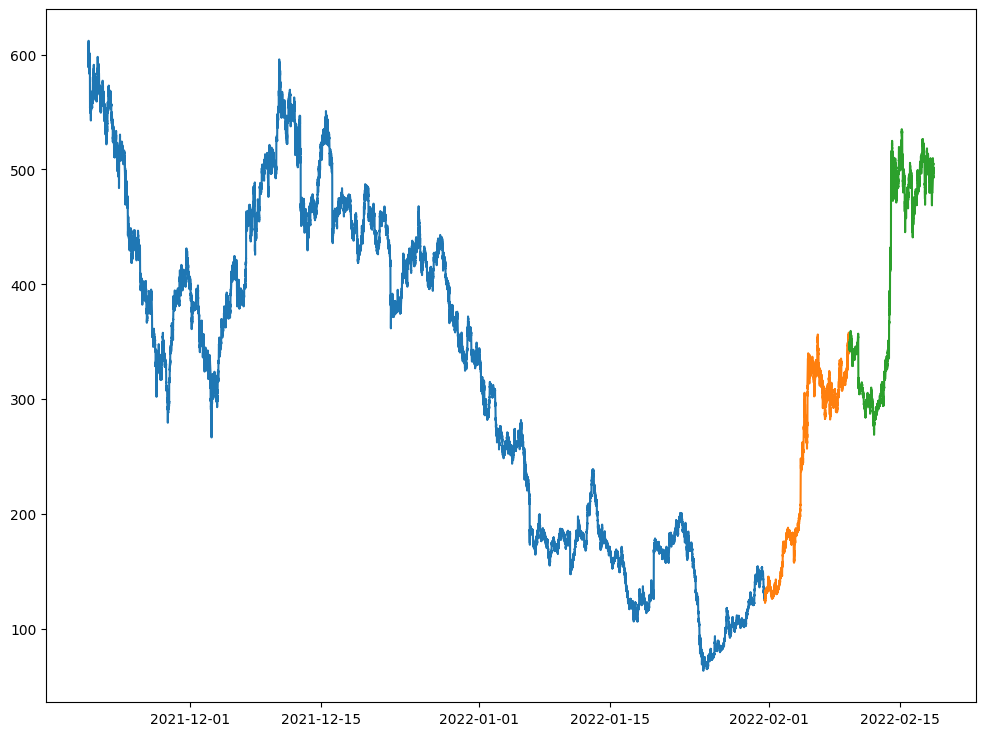

In [10]:

steps = 10
X, Y = train_test_data(data_daily.tolist(), steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

Training_size = int(len(data_daily)*0.8)
size = Training_size
Training_Validation_size = int(((len(data_daily)-size)/2)+size)

X_train, Y_train = X[:Training_size], Y[:Training_size]
X_val, Y_val = X[Training_size:Training_Validation_size], Y[Training_size:Training_Validation_size]
X_test, Y_test = X[Training_Validation_size:], Y[Training_Validation_size:]

print('Training size:', Training_size)
print('Training + Validation size:', Training_Validation_size)

train_test_validation_plot(Training_size, Training_Validation_size)

In [11]:
mse_train = list()
mse_val = list()
for epoch in range(0,20,5):
    # fit the model with epochs
    model_fit = model.fit(X_train, Y_train, epochs=epoch, verbose=1)
    
    #model evaluation
    Train_pred = model.predict(X_train, verbose=0)
    Val_pred = model.predict(X_val, verbose=0)
    
    #computing the training and validation loss
    mse_t = mean_squared_error(Train_pred, Y_train)
    mse_v = mean_squared_error(Val_pred, Y_val)
    mse_train.append(mse_t)
    mse_val.append(mse_v)

Epoch 1/5

3259/3259 [==============================] - 11s 3ms/step - loss: 780.5417
Epoch 2/5
3259/3259 [==============================] - 10s 3ms/step - loss: 8.9247
Epoch 3/5
3259/3259 [==============================] - 10s 3ms/step - loss: 4.0179
Epoch 4/5
3259/3259 [==============================] - 9s 3ms/step - loss: 23.3631
Epoch 5/5
3259/3259 [==============================] - 9s 3ms/step - loss: 31.4218
Epoch 1/10
3259/3259 [==============================] - 10s 3ms/step - loss: 3.8762
Epoch 2/10
3259/3259 [==============================] - 10s 3ms/step - loss: 4.1555
Epoch 3/10
3259/3259 [==============================] - 10s 3ms/step - loss: 3.6303
Epoch 4/10
3259/3259 [==============================] - 10s 3ms/step - loss: 4.7184
Epoch 5/10
3259/3259 [==============================] - 10s 3ms/step - loss: 2.2732
Epoch 6/10
3259/3259 [==============================] - 10s 3ms/step - loss: 2.3752
Epoch 7/10
3259/3259 [==============================] - 10s 3ms/step - loss: 2

In [12]:
def plot_loss_results(mse_train, mse_val):
    plt.plot(range(0,20,5), mse_train, label='Train loss')
    plt.plot(range(0,20,5), mse_val,  label='Validation loss')
    plt.legend()
    print('Train MSE minimum:', min(mse_train))
    print('Validation MSE minimum:', min(mse_val))

Train MSE minimum: 0.9116502089758179
Validation MSE minimum: 0.8946435865193773


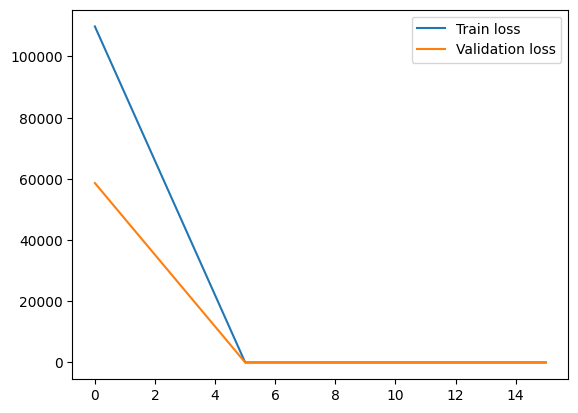

In [13]:
plot_loss_results(mse_train, mse_val)

Train MSE minimum: 1.0434235334396362


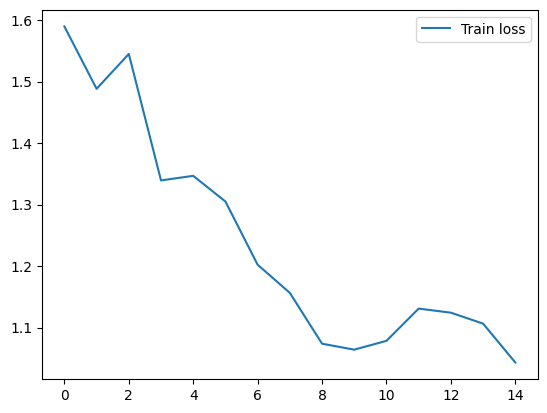

In [14]:
plt.plot(model_fit.history['loss'], label='Train loss')
plt.legend()
print('Train MSE minimum:', min(model_fit.history['loss']))

In [15]:
Train_pred = model.predict(X_train, verbose=0)
Y_pred = model.predict(X_test, verbose=0)

print(len(Y_pred.flatten().tolist()))

13025


MSE: 1.70155
RMSE: 1.30444
MAE: 0.738
MAPE: 0.263
MASE: inf
R^2 score: 1.000


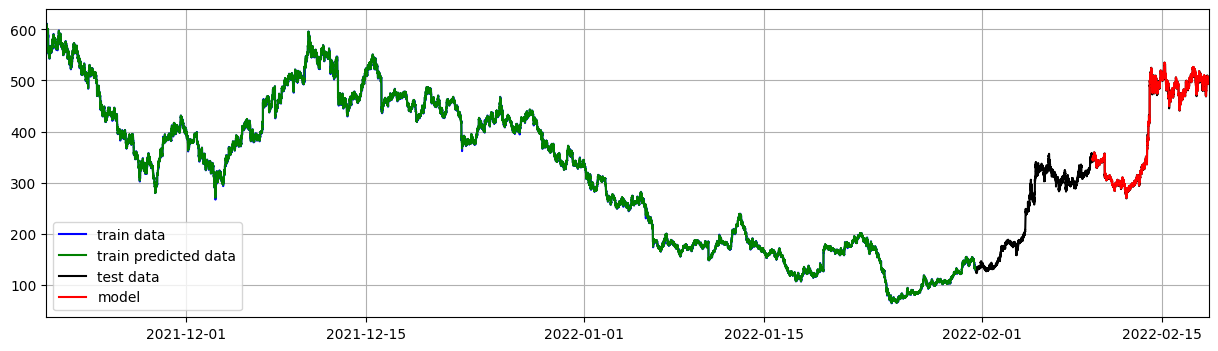

In [18]:
Y_pred_series = pd.Series(Y_pred.flatten().tolist(), index=data_daily[size+(np.abs(len(Y_pred.flatten().tolist()) - len(data_daily[size:].index))):].index)
Train_pred_series = pd.Series(Train_pred.flatten().tolist(), index=data_daily[:size].index)

#Plot
plt.figure(figsize=(15,4))
plt.plot(data_daily[:size], c='blue',label='train data')
plt.plot(Train_pred_series, c='green',label='train predicted data')
plt.plot(data_daily[size:], c='black',label='test data')
plt.plot(Y_pred_series, c='red', label='model')
plt.legend()
plt.grid(), plt.margins(x=0);

# calc error
print('MSE: %.5f' % (mean_squared_error(Y_pred, Y_test)))
print('RMSE: %.5f' % np.sqrt(mean_squared_error(Y_pred, Y_test)))
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = np.mean(np.abs(Y_pred - Y_test)/np.abs(Y_test))
MASE = np.mean(np.abs(Y_pred - Y_test))/(np.abs(np.diff(X_train)).sum()/(len(X_train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(Y_test, Y_pred))

In [ ]:
import pickle

# Guardar el modelo en un archivo pickle
with open('lstm.pkl', 'wb') as f:
    pickle.dump(model, f)